# Машинное обучение, ФКН ВШЭ

## Практическое задание 4. Классификация

### Общая информация
Дата выдачи: 09.11.2023

Мягкий дедлайн: 22.11.2023

Жесткий дедлайн: 26.11.2023

### О задании

В этом задании вы:
- ознакомитесь с тем, что происходит "внутри" метода опорных векторов и логистической регрессии
- познакомитесь с калибровкой вероятности
- изучите методы трансформации переменных и методы отбора признаков
- попробуете оценить экономический эффект модели

----

#### Самостоятельная оценка результатов

Для удобства проверки, исходя из набора решенных задач, посчитайте свою максимальную оценку.

**Оценка**: 10.0 (Я задолбался даже без бонусов)))

### Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного жёсткого дедлайна нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи

Для сдачи задания переименуйте получившийся файл *.ipynb в соответствии со следующим форматом: homework-practice-04-linclass-__Username__.ipynb, где Username — ваша фамилия и имя на латинице именно в таком порядке (например, homework-practice-04-linclass-__IvanovIvan__.ipynb).

In [234]:
    from sklearn.metrics import auc
    from sklearn.metrics import average_precision_score
    from sklearn.metrics import precision_recall_curve
    from sklearn.metrics import PrecisionRecallDisplay

    from sklearn.metrics import roc_auc_score
    from sklearn.metrics import RocCurveDisplay

    from sklearn.linear_model import LogisticRegression
    from sklearn.svm import SVC
    from sklearn.model_selection import GridSearchCV
    from sklearn.metrics import make_scorer
    from sklearn.datasets import make_classification
    from sklearn.model_selection import train_test_split
    from sklearn.dummy import DummyClassifier

    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    %matplotlib inline

    pd.set_option('display.max_rows', 100)
    pd.set_option('display.max_columns', 100)

In [235]:
def depict_pr_roc(y_true, y_pred, classifier_name='Some Classifier', ax=None, plot=False, return_roc=False, verbose=True):
  if plot:
    if ax is None:
        fig, ax = plt.subplots(1, 2, figsize=(11, 5))
  if verbose:
    print(classifier_name, 'metrics')
  precision, recall, _ = precision_recall_curve(y_true, y_pred)
  if verbose:
    print('AUC-PR: %.5f' % auc(recall, precision))

  if plot:
    PrecisionRecallDisplay.from_predictions(y_true, y_pred, ax=ax[0], name=classifier_name)


    ax[0].set_title("PRC")
    ax[0].set_ylim(0, 1.1)

    RocCurveDisplay.from_predictions(y_true, y_pred, ax=ax[1], name=classifier_name)
    print('AUC-ROC: %.5f' % roc_auc_score(y_true, y_pred))
    ax[1].set_title("ROC")
    ax[1].set_ylim(0, 1.1)

    plt.tight_layout()
    plt.legend()

  if return_roc:
    return roc_auc_score(y_true, y_pred), auc(recall, precision)
  else:
    return auc(recall, precision)



# Часть 1. SVM, LR и калибровка вероятностей (2 балла + 0.5 бонус)

#### __Задание 1.1  Сравнение методов__ (0.5 балла)



Сгенерируем синтетические данные.

In [204]:
# фиксируем random_state для воспроизводимости результатов
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

__Случайный классификатор__

Для начала зададим самую простую модель, которая на каждом объекте выдаёт случайный ответ. По тестовой выборке вычислим AUC-ROC, AUC-PR.

In [205]:
from sklearn.dummy import DummyClassifier
random_classifier = DummyClassifier(strategy='uniform', random_state=42).fit(X_train, y_train)
y_random = random_classifier.predict_proba(X_test)[:,1]
y_random

array([0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5])

**Вопрос:** решаем задачу бинарной классификации, но y\_random содержит какие-то дробные числа, а не 0/1. Почему?



**Ответ**: Потому что это не предсказания классов, а уверенность модели (вероятности) так как у нас глупая модель, она выбирает класс по принципу подброса монетки

*Ниже приведен **пример** работы* со встроенными функциями `sklearn` для отрисовки ROC и PR кривых, сохранения метрик. Пайплайн можно изменять как вам удобно.

Random Classifier metrics
AUC-PR: 0.75283
AUC-ROC: 0.50000


0.7528333333333334

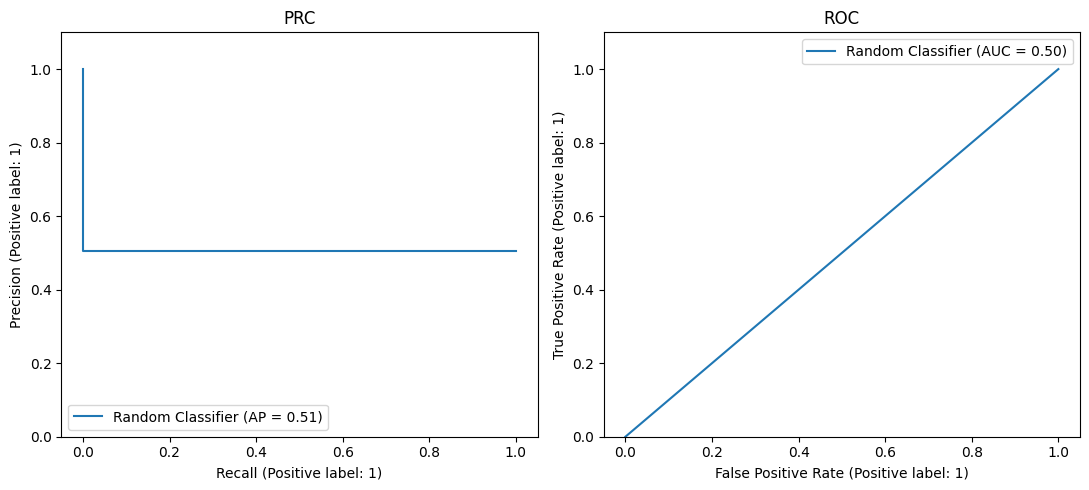

In [206]:
depict_pr_roc(y_test, y_random, 'Random Classifier', plot=True)


In [207]:
# dataframe для сравнения
# методов классификации по метрикам
df_metrics = pd.DataFrame(columns=['AUC_PR', 'AUC_ROC', 'reg_const'])
precision, recall, _ = precision_recall_curve(y_test, y_random)
  # добавление очередной строки с характеристиками метода
df_metrics.loc['Random Classifier'] = [
      auc(recall, precision),
      roc_auc_score(y_test, y_random),
      0
]

  # по аналогии результаты следующих экспериментов можно будет собрать в табличку
df_metrics

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.752833,0.5,0.0


__Support Vector Machine (Linear Kernel)__

Обучите метод опорных векторов.

На занятиях мы проходили линейный вариант без ядрового перехода, что соответствует линейному ядру (`LinearSVC` или же `SVC(kernel='linear')` в `sklearn.svm`).

Подберите параметр регуляризации `C` с точки зрения AUC-PR (можете воспользоваться кросс-валидацией или отделить валидационную выборку от обучающей).


In [208]:
# also tested for 10, 100, 1000

param_grid = [
  {'C': [0.01, 0.1, 1], 'kernel': ['linear']},
 ]

svc = SVC()

cv = GridSearchCV(svc, param_grid, cv=3, scoring=make_scorer(depict_pr_roc) ).fit(X, y)

Some Classifier metrics
AUC-PR: 0.83013
Some Classifier metrics
AUC-PR: 0.83184
Some Classifier metrics
AUC-PR: 0.83652
Some Classifier metrics
AUC-PR: 0.83077
Some Classifier metrics
AUC-PR: 0.83358
Some Classifier metrics
AUC-PR: 0.83697
Some Classifier metrics
AUC-PR: 0.83055
Some Classifier metrics
AUC-PR: 0.83380
Some Classifier metrics
AUC-PR: 0.83697


In [209]:
cv.best_params_

{'C': 0.1, 'kernel': 'linear'}

  На тестовой части:
  - постройте ROC и PR кривые,
  - посчитайте AUC-ROC, AUC-PR с точностью до 5 знаков

In [210]:
best_svc = SVC(C=1, kernel="linear", probability=True)

best_svc.fit(X_train, y_train)
# y_svc = best_svc.predict_proba(X_test)[:,1]
y_svc = best_svc.decision_function(X_test)

SVM metrics
AUC-PR: 0.81488
AUC-ROC: 0.84790


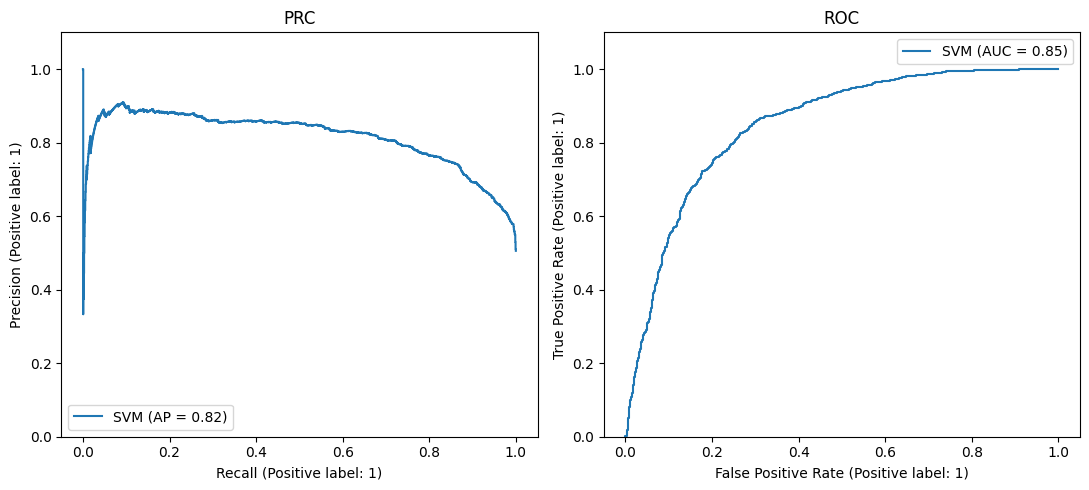

In [211]:
auc_roc, auc_pr = depict_pr_roc(y_test, y_svc, 'SVM', plot=True, return_roc=True)

Сравните AUC-ROC и AUC-PR для вашей модели с этими же метриками для случайного классификатора.

In [212]:
# AUC-ROC сильно улучшился. AUC-PR тоже улучшился, но меньше
df_metrics

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.752833,0.5,0.0


In [213]:
auc_pr.round(5), auc_roc.round(5)

(0.81488, 0.8479)

__Logistic Regression__


Аналогичное задание для логистической регрессии с L2 регуляризатором:


*   подберите гиперпараметр C, используя метрику AUC-PR
*   нарисуйте ROC, PR кривые для тестовой части
*   выведите метрики для тестовых данных и сравните их с результатами случайного классификатора



In [214]:
# also tested for 10, 100, 1000
ridge = LogisticRegression()

param_grid = {'C': [0.01, 0.1, 1], "penalty": ["l2"]}

cv = GridSearchCV(ridge, param_grid, cv=3, scoring=make_scorer(depict_pr_roc) ).fit(X, y)

Some Classifier metrics
AUC-PR: 0.83076
Some Classifier metrics
AUC-PR: 0.83260
Some Classifier metrics
AUC-PR: 0.83497
Some Classifier metrics
AUC-PR: 0.83094
Some Classifier metrics
AUC-PR: 0.83081
Some Classifier metrics
AUC-PR: 0.83655
Some Classifier metrics
AUC-PR: 0.83094
Some Classifier metrics
AUC-PR: 0.83081
Some Classifier metrics
AUC-PR: 0.83701


In [215]:
cv.best_params_

{'C': 1, 'penalty': 'l2'}

Logistic Regression metrics
AUC-PR: 0.82912
AUC-ROC: 0.84787


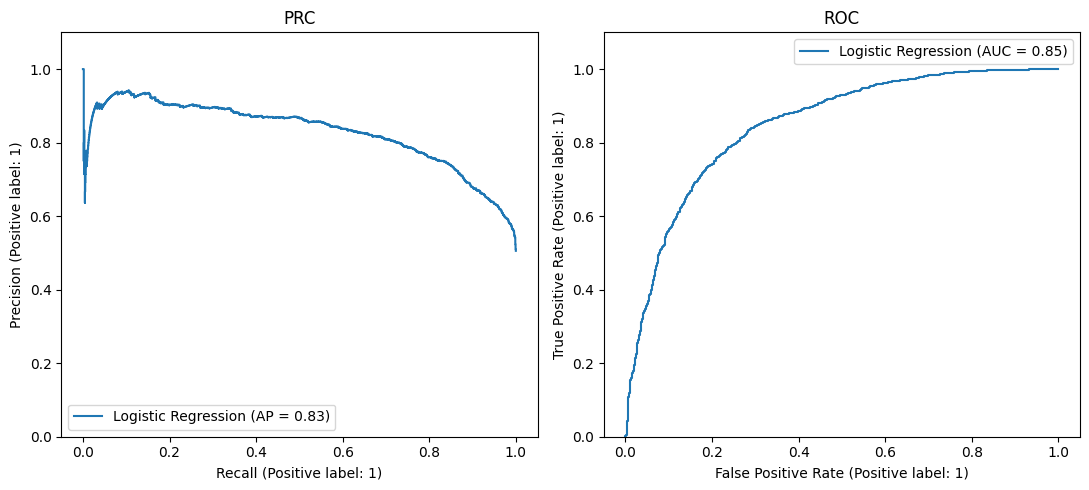

In [216]:
best_logreg = LogisticRegression(**cv.best_params_).fit(X_train, y_train)


y_logreg_proba = best_logreg.predict_proba(X_test)[:,1]
auc_roc, auc_pr = depict_pr_roc(y_test, y_logreg_proba, 'Logistic Regression', plot=True, return_roc=True)

In [217]:
# Похожая ситуация

df_metrics

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.752833,0.5,0.0


In [218]:
auc_pr.round(5), auc_roc.round(5)

(0.82912, 0.84787)

Нарисуйте ROC, PR кривые для тестовой части для всех 3 классификаторов на одном графике

Random metrics
AUC-PR: 0.75283
AUC-ROC: 0.50000
SVC metrics
AUC-PR: 0.81488
AUC-ROC: 0.84790
Logistic Regression metrics
AUC-PR: 0.82912
AUC-ROC: 0.84787


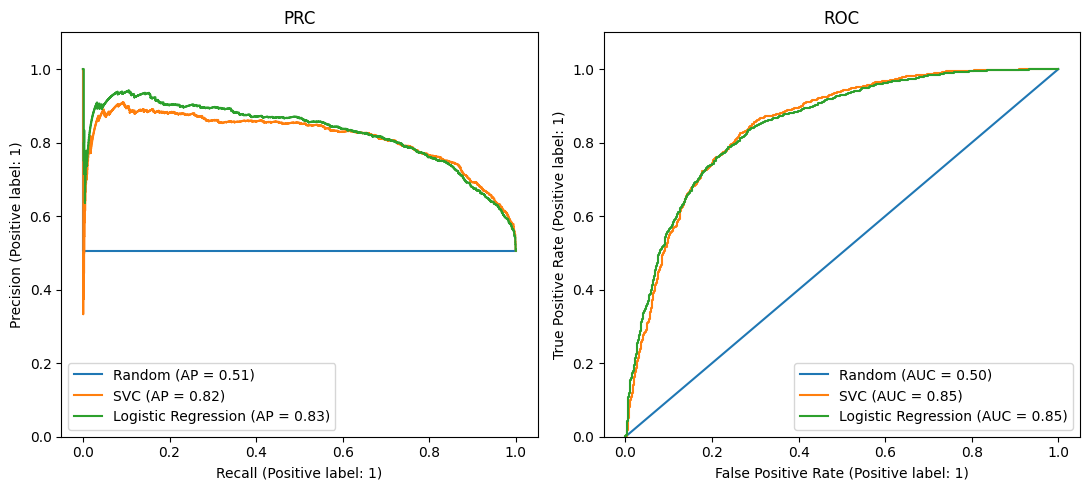

In [219]:
classifier_name = "All classifiers"
y_true = y_test
y_pred = y_random

fig, ax = plt.subplots(1, 2, figsize=(11, 5))

classifiers = ["Random", "SVC", "Logistic Regression"]
y_pred_list = [y_random, y_svc, y_logreg_proba]

for classifier_name, y_pred in zip(classifiers, y_pred_list):
    print(classifier_name, 'metrics')
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    print('AUC-PR: %.5f' % auc(recall, precision))

    PrecisionRecallDisplay.from_predictions(y_true, y_pred, ax=ax[0], name=classifier_name)

    RocCurveDisplay.from_predictions(y_true, y_pred, ax=ax[1], name=classifier_name)
    print('AUC-ROC: %.5f' % roc_auc_score(y_true, y_pred))

ax[0].set_title("PRC")
ax[0].set_ylim(0, 1.1)

ax[1].set_title("ROC")
ax[1].set_ylim(0, 1.1)

plt.tight_layout()
plt.legend()

**Вопрос:** Сравните результаты LR и SVM с точки зрения всех вычисленных критериев качества, объясните различия (если они есть).

**Ответ:** Результаты очень похожи, скорее всего не существенное отличие. Можно заметить, что LR может добиться чуть большего пресижна, а SVC чуть большего Recall. Соответсвенно, если мы хотим максимизировать то, насколько мы верим в положительное предсказание, берем LR, а если нам важнее выявить как можно больше True Positive (ценой False Positive), то берем SVC.

#### __Задание 1.2. Визуализация в подходах SVM, LR__ (0.5 балла)



В названии метода опорных векторов присутствуют некоторые "опорные векторы". По сути, это объекты из обучающей выборки, которые задали положение разделяющей гиперплоскости.

* Сгенерируйте синтетические данные с помощью `make_classification` __с 2 признаками__, обучите на нём метод опорных векторов. В этот раз воспользуйтесь `SVC(kernel='linear')`, так как только в нём есть информация об опорных векторах, а в `LinearSVC` нет. Не забудьте зафиксировать seed для воспроизводимости

* Визуализируйте разделяющую прямую, все объекты и выделите опорные векторы (атрибут `support_vectors_`).

In [220]:
X, y = make_classification(
    n_samples=10000, n_features=2, n_informative=2, n_redundant=0, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [221]:
svc = SVC(kernel='linear', C=1).fit(X_train, y_train)

y_pred = svc.predict(X_test)

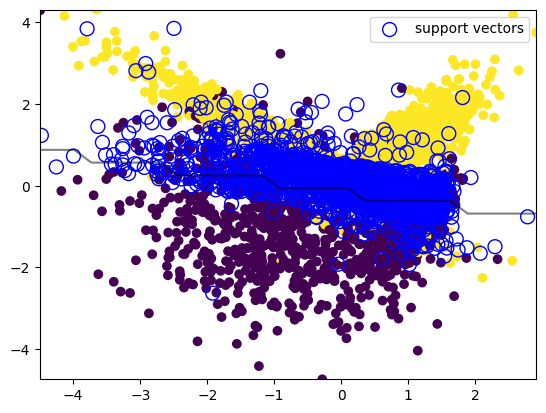

In [222]:
def plot_svm_2D(X, y, model,  plot_support=True):

    #создали сетку
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 30)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    #Ответы модели для сетки для отрисовки разделяющей прямой
    Z = model.predict(xy).reshape(XX.shape)

    plt.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])


    #Отрисовали выборку
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis')

    #Отрисовали опорные векторы
    if plot_support:
        support_vectors = model.support_vectors_
        plt.scatter(support_vectors[:, 0], support_vectors[:, 1],
                   label='support vectors',
                   s=100,
                   linewidth=1,
                   edgecolor="blue",
                   facecolors='none')

    plt.legend()

plot_svm_2D(X_test, y_test, svc)

**Вопрос:** какие объекты выделяются как "опорные"?



**Ответ:** Зачастую это те объекты, по которым строится гипер-плоскость. Это те вектора, которые показывают, как надо её провести, чтобы отделить классы

В отличие от метода опорных векторов, логистическая регрессия не пытается построить разделяющую гиперплоскость с максимальным отступом, а приближает в каждой точке пространства объектов вероятность положительных ответов $p(y=+1|x)$. Попробуйте нарисовать это распределение на плоскости, не забудьте отметить на ней все объекты.

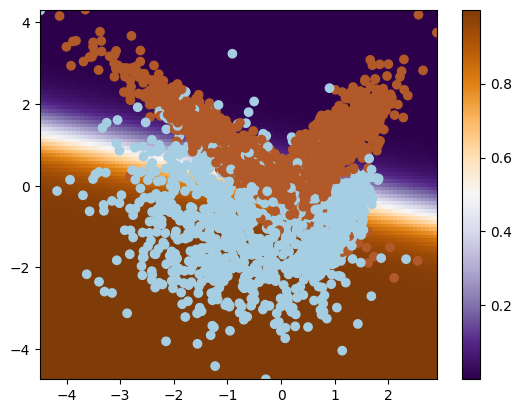

In [223]:
def plot_logreg_2D(X, y, model):

    #создали сетку
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 100)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 100)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    #Ответы модели для сетки для отрисовки распределения
    Z = model.predict_proba(xy)[:, 0]
    Z = Z.reshape((xx.shape[0], -1)).T


    image = plt.imshow(Z, interpolation='nearest',
                       extent=(xx.min(), xx.max(), yy.min(), yy.max()),
                       aspect='auto', origin='lower', cmap=plt.cm.PuOr_r)

    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)

    plt.colorbar(image)

ridge = LogisticRegression(**{'C': 1, "penalty": "l2"}).fit(X_train, y_train)

plot_logreg_2D(X_test, y_test, ridge)

In [224]:
ridge.predict_proba(X_test)[:, 0] + ridge.predict_proba(X_test)[:, 1]

array([1., 1., 1., ..., 1., 1., 1.])

**Вопрос:** Как на картинке визуализирована область, где модель не уверена ($p(y=+1|x) = 0.5$)? Как это обосновать теоритечески?



**Ответ:** Прямой линией, лучше всего разделяющей два множества объектов. Теоретическое обоснование: логистическая регрессия использует Cross Entropy Функцию потерь, эта функция потерь максимально приближена к тому, какова вероятность того что при похожих x, мы получим положительный класс. Скалярное произведение - расстояние от этой линии разделяющей прямой до точки. На этой линии это расстояние близится к нулю, после этого мы применяем сигмоиду и получаем
$$
\lim_{<w,x>->0}b(w,x) = \sigma (0) = \frac{1}{1+e^{0}} = \frac{1}{2}
$$

#### __Задание 2. Калибровка вероятностей__ (1 балл)



Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых.

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность?

Хорошо откалиброванный  классификатор должен выдавать значения так, чтобы среди образцов, для которых он дал значение, близкое к $\alpha$, примерно $\alpha * 100 \%$ фактически принадлежали к положительному классу. (Например, если классификатор выдает 0.3 для некоторых, то 30% из них должны принадлежать классу 1)

Для построения калибровочной криовой используем следующий алгоритм:

Разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины.

Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной.

Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

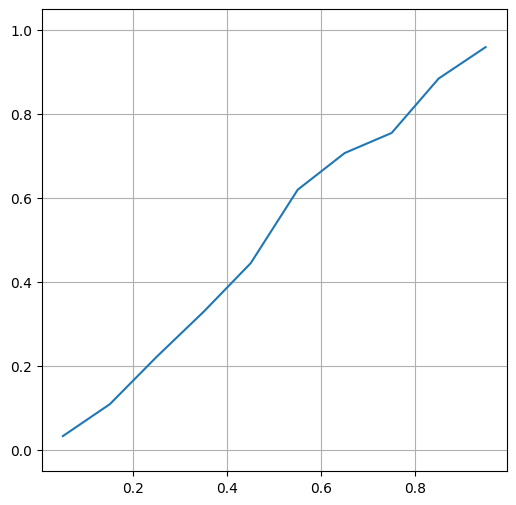

In [225]:
# I DIED WHILE WAS DOING THIS....
def plot_calibration_curve(y_test, preds, ax=None,label="Model"):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((l + r) / 2)
        current_sample = y_test[(preds < r) & (preds >= l)]
        real_class_ratio = len(current_sample[current_sample == 1]) / (len(current_sample))
        bin_real_ratios.append(real_class_ratio)

    if not ax:
        plt.figure(figsize=(6,6))
        plt.ylim([-0.05, 1.05])
        plt.grid()
    plt.plot(bin_middle_points, bin_real_ratios, label=label)


    return bin_middle_points, bin_real_ratios

_ = plot_calibration_curve(y_test, ridge.predict_proba(X_test)[:,1])


Сгенерируйте синтетические данные аналогично использованным в самом первом задании. Постройте калибровочные кривые на тестовой части для логистической регрессии и метода опорных векторов (не забудьте перевести его предсказания в $[0;1]$).

Отрисуйте калибровочную кривую идеально откалиброванной модели (диагональ)

In [226]:
X, y = make_classification(
    n_samples=10000, n_features=2, n_informative=2, n_redundant=0, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [227]:
def decision_norm(model, X):
    preds = model.decision_function(X_test)
    return (preds - preds.min()) / (preds.max() - preds.min())

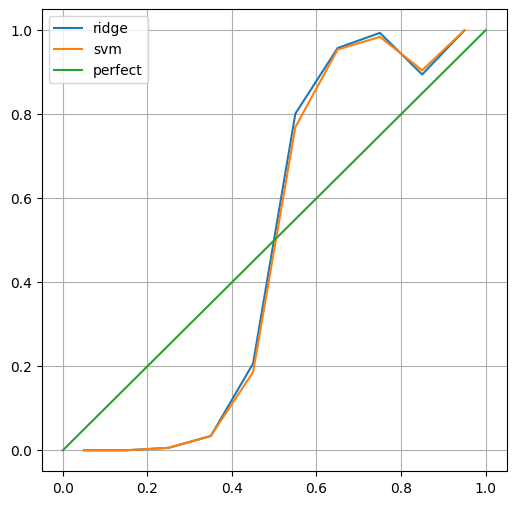

In [228]:
ridge = LogisticRegression( C=1).fit(X_train, y_train)
svc = SVC(C=1, kernel='linear', probability=True).fit(X_train, y_train)

plt.figure(figsize=(6,6))
plt.ylim([-0.05, 1.05])
plt.grid()

_ = plot_calibration_curve(y_test, decision_norm(ridge, X_test), ax=1, label="ridge")
_ = plot_calibration_curve(y_test, decision_norm(svc, X_test), ax=1, label="svm")

plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100), label="perfect")

plt.legend()
plt.show()

**Вопрос**: хорошо ли откалиброваны кривые для SVM, логистической регрессии?

**Ответ:** Обе кривые плохо откалиброваны

Изучите распределение ответов классификаторов (постройте гистограммы с помощью `plt.hist`).

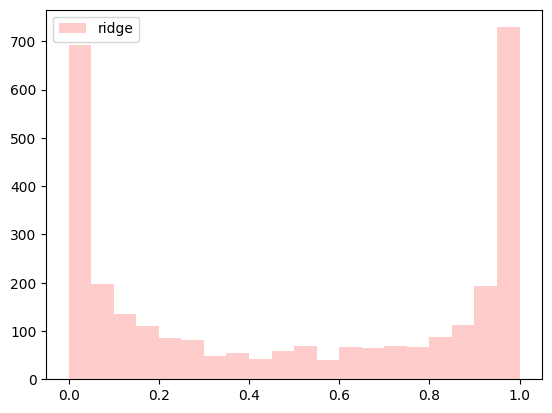

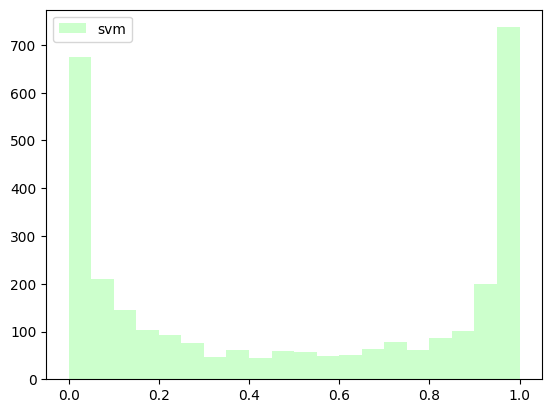

In [229]:
from random import randrange

def analyze_classifier(model, X, label="model", rgb=(0,0,1)):
    probabilities = model.predict_proba(X)[:,1]

    plt.hist(probabilities, label=label, fc=rgb + tuple([0.2]),bins=20)
    plt.legend()

analyze_classifier(ridge, X_test, "ridge", rgb=(1,0,0))
plt.show()

analyze_classifier(svc, X_test, "svm", rgb=(0,1,0))

plt.show()

**Вопрос:** Чем они различаются? Чем вы можете объяснить это?

**Ответ:** Честно говоря -- Ужасно похожи. Но логистическая регрессия кажется чуть менее гладкой, в том смысле, что если представить, что эта выборка взята из генеральной совокупности с гладкой функцией, то svm график лучше бы это обобщал. Неформально - разница между бинами больше у логистической регрессии. Логистическая регрессия лучше предсказывает вероятности, возможно в этом причина. SVM выглядит более гладкой идеальной версией, которой данные обычно не являются.

Воспользуйтесь `CalibratedClassifierCV` из `sklearn` для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью  предсказания для тестовой выборки.

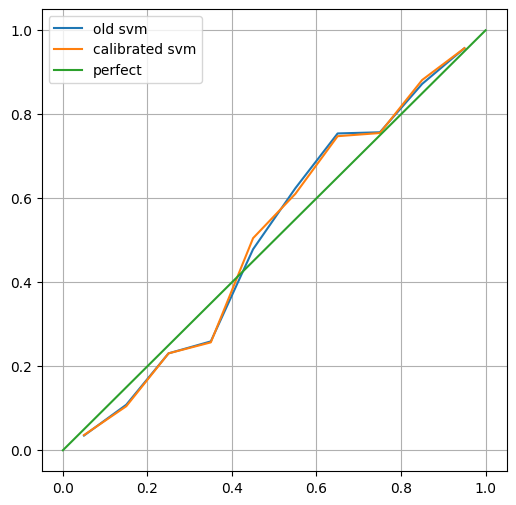

In [230]:
from sklearn.calibration import CalibratedClassifierCV

svm_cv = CalibratedClassifierCV(SVC(kernel="linear", C=1, probability=True), cv=2).fit(X_train, y_train)

preds = svm_cv.predict(X_test)

plt.figure(figsize=(6,6))
plt.ylim([-0.05, 1.05])
plt.grid()

_ = plot_calibration_curve(y_test, svc.predict_proba(X_test)[:,1], ax=1, label="old svm")
_ = plot_calibration_curve(y_test, svm_cv.predict_proba(X_test)[:,1], ax=1, label="calibrated svm")

plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100), label="perfect")

plt.legend()
plt.show()

**Вопрос:** Улучшилась ли калибровочная кривая?

**Ответ:** Ну... Нет. В некоторых местах даже стала хуже.

##### __Бонус: Авторское решение__ (0.5 балла)

Реализуйте свою функцию для калибровки вероятностей, используя любой из известных подходов. Кратко опишите ваш подход и продемонстрируйте результаты. Ключевые слова для вдохновения: `Platt`, `Isotonic`.

In [231]:
#your code here

# Часть 2. Обработка категориальных переменных (4 балла + 1.5 бонус)

Как мы знаем, перекодировать категориальную переменную в список чисел (к примеру 1, 2, 3, ..., n) плохо, поскольку это бы задало на множестве ее значений некоторый порядок, не имеющий смысла.

В этой части мы рассмотрим два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

#### __Подготовка данных__

(бесценный шаг)

Разберем датасет [покупок велосипедов](https://www.kaggle.com/datasets/heeraldedhia/bike-buyers/): даны признаки покупателя, требуется предсказать, купит ли он/она велосипед



Замените пропуски в категориальных переменных на новую категорию (`'undefined'`)

Разделите признаки на 2 таблицы: категориальные и числовые признаки

In [232]:
df = pd.read_csv('bike_buyers.csv')
print(df.shape)

num_cols = ["ID", "Income", "Age"]
cat_cols = ["Marital Status", "Gender", "Children", "Education", "Occupation", "Home Owner", "Cars", "Commute Distance", "Region"]


#Заменим пропуски категориальных переменных
df = df.apply(lambda x: x.fillna(x.value_counts().index[0]) if x.name in cat_cols else x)

X = df.drop(columns=['Purchased Bike'])
y = (df['Purchased Bike'] == 'Yes').astype('int64')

FileNotFoundError: ignored

In [ ]:
df.head()

In [ ]:
df.isnull().values.any()

In [ ]:
#Разделим на категориальные признаки и числовые
X_numerical = df[num_cols]
X_categorical = df[cat_cols]

В начале поработаем только с категориальными признаками

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_categorical, y, test_size=0.25, random_state=777, stratify=y)

In [ ]:
X_train.shape, y_train.shape

#### __Задание 3. OrdinalEncoder__  (0.5 балла)

Закодируйте категориальные признаки с помощью `OrdinalEncoder`. Посчитайте качество (в этом задании будем работать c __`AUC-PR`__) при применении логистической регрессии. Замерьте время, потребовавшееся на обучение модели, с учетом кодирования признаков.

In [ ]:
%%time
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OrdinalEncoder

enc = OrdinalEncoder()
X_train_trans = enc.fit_transform(X_train)
X_test_trans = enc.transform(X_test)

log_reg_oe = LogisticRegression().fit(X_train_trans, y_train)
y_pred_proba = log_reg_oe.predict_proba(X_test_trans)[:,1]

auc_roc, auc_pr = depict_pr_roc(y_test, y_pred_proba, 'Logistic Regression OrdinalEncoder', plot=True, return_roc=True)

#### __Задание 4. One-Hot Encoding__ (0.5 балла)



Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (в сравнении с тем, что было до кодирования). Измерьте время, потребовавшееся на кодирование категориальных признаков и обучение модели.

In [ ]:
%%time
from sklearn.preprocessing import OneHotEncoder

# я на V100, поэтому все быстро
enc = OneHotEncoder()
X_train_trans = enc.fit_transform(X_train)
X_test_trans = enc.transform(X_test)

log_reg_ohe = LogisticRegression().fit(X_train_trans, y_train)
y_pred = log_reg_ohe.predict_proba(X_test_trans)[:,1]

auc_roc, auc_pr = depict_pr_roc(y_test, y_pred, 'Logistic Regression OrdinalEncoder', plot=True, return_roc=True)

Как можно заметить, one-hot-кодирование может сильно увеличивать количество признаков. Это сказывается на объеме необходимой памяти, особенно, если некоторый признак имеет большое количество значений.


#### __Задание 5. Mean-target Encoding__ (1 балл)

> Проблемы разрастания числа признаков можно избежать в другом способе кодирования категориальных признаков — mean-target encoding (для простоты будем называть это __счётчиками__). Сравним эффективность методов в рамках нашей маркетинговой задачи.

> Основная идея в том, что важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:

$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)]}
$$

Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше, без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве.

Сравните время обучения с предыдущими экспериментами (с учетом кодирования признаков).

In [ ]:
%%time

class MTE:
    def fit_transform(self, X: pd.DataFrame, y: np.array):
        """
        X: dataframe of only categorical variables
        y: real target variable
        """
        transformed_X = X.copy()
        mean_targets_on_train = {}

        for cat_col in X.columns:
            series = X[cat_col]
            transformed_series = np.empty(shape=series.shape)
            mean_targets_on_train[cat_col] = dict()
            for category in series.unique():
                mean_target = np.sum(y[series == category]) / len(series[series == category])
                transformed_series[series == category] = mean_target
                mean_targets_on_train[cat_col][category] = mean_target

            transformed_X[cat_col] = transformed_series

        self.mean_targets_on_train = mean_targets_on_train
        return transformed_X

    def transform(self, X:pd.DataFrame):
        """
        X: dataframe of only categorical variables
        y: real target variable
        """
        transformed_X = X.copy()
        for cat_col in X.columns:
            series = X[cat_col]
            transformed_series = np.empty(shape=series.shape)
            for category in series.unique():
                transformed_series[series == category] = self.mean_targets_on_train[cat_col][category]
            transformed_X[cat_col] = transformed_series

        return transformed_X

mte_enc = MTE()
X_train_mte = mte_enc.fit_transform(X_train, y_train)
X_test_mte = mte_enc.transform(X_test)

log_reg_mte = LogisticRegression().fit(X_train_mte, y_train)
y_pred = log_reg_mte.predict_proba(X_test_mte)[:,1]

auc_roc, auc_pr = depict_pr_roc(y_test, y_pred, 'Logistic Regression OrdinalEncoder', plot=True, return_roc=True)


# display(mte(X_train, y_train).head())
# display("-"*100)
# display(X_train.head())

##### __Бонус: Эффективная реализация (1 балл)__

Здесь и далее реализуйте вычисление счетчиков с помощью трансформера (наследуйтесь от классов `BaseEstimator, TransformerMixin` из `sklearn.base`). Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики нужно считать только по обучающей выборке в методе `fit`. Ваш трансформер должен принимать при инициализации список из категориальных признаков и изменять только их.

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from typing import List


class MTE(BaseEstimator, TransformerMixin):
    def __init__(self, cat_cols: List[str]):
        self.cat = cat_cols
        pass

    def fit(self, X: pd.DataFrame = None, y: np.array = None):
        # your code here
        return self

    def transform(self, X: pd.DataFrame, y: np,array = None):
        # your code here
        return X

_______

__Методы борьбы с переобучением счетчиков__


Отметим, что mean-target encoding признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к __переобучению__, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении для конкретного объекта его __целевая метка не использовалась__.

Это можно делать следующими способами:
1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации).
3. Внесение некоторого шума в посчитанные признаки.

#### __Задание 6. Пошумим__  (0.5 балла)

Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям.  При этом постарайтесь найти баланс между борьбой с переобучением и сохранением полезности признаков. Снова обучите логистическую регрессию, оцените качество.

In [ ]:
def introduce_noise(X: pd.DataFrame, alpha=10):
    # Standard normal noise
    random_noise = np.random.randn(*X.shape) / alpha
    return X + random_noise

alphas = [1, 10, 25, 66, 100, 1000, np.inf]
metrics = []
for a in alphas:
    mte = MTE()

    X_train_mte_noisy = introduce_noise(X_train_mte, alpha=a)
    # X_test_mte_noisy = introduce_noise(X_test_mte, alpha=a)

    log_reg_noisy = LogisticRegression().fit(X_train_mte_noisy, y_train)

    y_pred = log_reg_noisy.predict_proba(X_test_mte)[:,1]
    auc_roc, auc_pr = depict_pr_roc(y_test, y_pred, 'Logistic Regression OrdinalEncoder', plot=False, return_roc=True)
    metrics.append((auc_roc, auc_pr))
    print(f"AUC-ROC: {auc_roc}")

plt.plot(metrics)
# plt.xscale("log")

Чем меньше шума, тем больше метрики

In [ ]:
a = 25

X_train_mte_noisy = introduce_noise(X_train_mte, alpha=a)

log_reg_noisy = LogisticRegression().fit(X_train_mte_noisy, y_train)

y_pred = log_reg_noisy.predict_proba(X_test_mte)[:,1]
auc_roc, auc_pr = depict_pr_roc(y_test, y_pred, 'Logistic Regression OrdinalEncoder', plot=True, return_roc=True)
metrics.append((auc_roc, auc_pr))
print(f"AUC-ROC: {auc_roc}")

**Вопрос:** Сделайте выводы. Помогло ли добавление шума? Почему?

**Ответ:** Шум не помог. Идея была в том, что давайте не запоминать выборку, чтобы не переобучаться, однако видимо выборка слишком хетерогенная, чтобы добавление шума как-то влияло на ситуацию

##### __Бонус: другой подход__ (0.5 балла)

Посчитайте корректные счётчики первым или вторым способов из описанных выше (не забудьте добавить и шум).




In [ ]:
#your code here

#### __Задание 7. Сглаживание счетчиков__  (1 балл)

> Теперь ответим на следующий вопрос: что будет, если некоторая категория встречается в выборке всего несколько раз? По этой причине производится сглаживание счётчиков. Например, на практике хорошие результаты показывает использование сглаживания средним по всей выборке:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1] + C \times global\_mean}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)] + C}
$$
где $global\_mean$ — доля объектов положительного класса в выборке, $C$ — параметр, определяющий степень сглаживания (можно использовать 10 или подобрать для каждого признака свой). Идея в том, что мы "разбавляем" среднее значение по категории глобальным средним значением. И тем меньше, чем большее количество объектов этой категории встречается в выборке.

> Вместо среднего значения целевой переменной для сглаживания можно использовать любое другое значение от 0 до 1 (этот параметр иногда называют $prior$). Можно сделать несколько признаков с разными значениями параметра. На практике в задачах бинарной классификации полезными бывают даже отрицательные значения!

Добавьте сглаживание, описанное выше и повторите эксперименты. Подберите $C$, чтобы качество было лучше, чем при использовании One-Hot-Encoding


### Ну... Я решил имплементнуть различные C для каждого признака

In [ ]:
class SmoothMTE(MTE):
    def __init__(self, c=10):
        self.c = c

    def fit_transform(self, X: pd.DataFrame, y: np.array):
        """
        X: dataframe of only categorical variables
        y: real target variable
        """
        transformed_X = X.copy()
        mean_targets_on_train = {}
        global_mean = np.count_nonzero(y == 1) / len(y)

        for i, cat_col in enumerate(X.columns):
            series = X[cat_col]
            transformed_series = np.empty(shape=series.shape)
            mean_targets_on_train[cat_col] = dict()
            for category in series.unique():
                mean_target = (np.sum(y[series == category]) + (self.c * global_mean) ) / (len(series[series == category]) + self.c)
                transformed_series[series == category] = mean_target
                mean_targets_on_train[cat_col][category] = mean_target

            transformed_X[cat_col] = transformed_series

        self.mean_targets_on_train = mean_targets_on_train
        return transformed_X

## Experiment Function

In [ ]:
def experiment(model, X_test, y_test, plot=True, verbose=True):
    """
    Returns: AUC-ROC, AUC-PR
    """
    y_pred = model.predict_proba(X_test)[:,1]
    auc_roc, auc_pr = depict_pr_roc(y_test, y_pred, 'Logistic Regression OrdinalEncoder', plot=plot, return_roc=True, verbose=verbose)
    return auc_roc, auc_pr

### Ну на OHE был AUC-ROC 0,715, щас будем побивать

In [ ]:
X_train.shape

In [ ]:
# C = np.logspace(np.logspace(0,0.5,10), np.logspace(0,1,10), 10)


In [ ]:
C = np.logspace(0, 3, 100)
# C = np.append(C, -C)

roc = []
pr = []

for c in C:
    # print("\nC: ", list(c))
    smte_enc = SmoothMTE(c=c)
    X_train_smte = smte_enc.fit_transform(X_train, y_train)
    X_test_smte = smte_enc.transform(X_test)

    logreg_smte = LogisticRegression().fit(X_train_smte, y_train)
    auc_roc, auc_pr = experiment(logreg_smte, X_test_smte, y_test, plot=False)

    roc += [auc_roc]
    pr += [auc_pr]

print(f"Best for ROC: {C[np.argmax(roc)]} ROC:{np.max(roc)}\nBest for PR: {C[np.argmax(pr)]} PR:{np.max(pr)}")

## ROC 0.701 для C=9.326... Ну почти

#### **Задание 8. Числовые или категориальные?**  (0.5 балла)

Теперь добавим числовые признаки к признакам-счетчикам.


В данных есть пропуски - замените их средним значением признака



In [ ]:
df.isnull().any()

In [ ]:
df = df.fillna(df.mean())

 Сейчас для числовых признаков мы ищем линейную зависимость, что в общем случае  может быть неверной гипотезой. Тем не менее, у этих признаков есть довольно много уникальных значений (сколько?), поэтому применять к ним one-hot кодирование может оказаться излишним. Попробуйте закодировать эти признаки с помощью счетчиков (вместе и по отдельности). Стало ли лучше?

In [ ]:
df[num_cols].drop("ID", axis=1).nunique().sum()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777, stratify=y)

smte = SmoothMTE(c=10)

X_train_smte = smte.fit_transform(X_train, y_train)
X_test_smte = smte.fit_transform(X_test, y_test) # Мне пришлось согрешить, по-другому не проходит

logreg_smte_num_cat = LogisticRegression().fit(X_train_smte, y_train)
experiment(logreg_smte_num_cat, X_test_smte, y_test)

### Стало... Но тут чисто ошибка при построении модели... Каюсь, я сделал два раза fit_transform. Я просто честно говоря не понимаю, как ожидается, что я сделаю это задание, потому что для числовых признаков, когда transform на зафиченном енкодере делаешь, в памяти нет для конкретных чисел правильного mean target... Поэтому не знаю, как бы там получилось, если бы не было дата лика. Думаю получилось бы нормально на самом деле. Кажется, чтобы это норм работало надо делать CV... But im lazy

> __Замечание.__ Усложнение методов вычисления счётчиков не делают результаты модели гарантированно лучше. Особенно с учётом того, что логистическая регрессия не такая сложная модель, чтобы переобучаться. Поэтому вы необязательно должны были получать на каждом шаге всё лучшие и лучшие результаты (но необходимые результаты у вас должны были получиться).



Как мы могли пронаблюдать, счётчики являются конкурентной альтернативой one-hot-кодированию. Опишите, какие плюсы и минусы использования счётчиков по сравнению с one-hot-кодированием вы заметили.

__Ответ:__ Плюсы: намного меньше признаков, быстрее работает, лучше метрики можно добиться <br> Минусы: сильно переобучается, требует CV, можно случайно ликнуть данные, надо париться об past-time encoding и тд, дополнительные гипер параметры в расширенных случаях

# Часть 3. Отбор признаков (2 балла)

Загрузим данные [UCI Adult Dataset](https://archive.ics.uci.edu/ml/datasets/Adult). Этот набор данных содержит информацию о годовых доходах отдельных людей. В качестве признакового описания используется различная информация о человеке (образование, профессия, брачный статус и т.д.). Целевая переменная является бинарной: больше ли годовой доход 50K долларов или нет.

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data

In [ ]:
columns = ['age', 'workclass', 'fnlwgt', 'education',
           'education-num', 'marital-status', 'occupation',
           'relationship', 'race', 'sex', 'capital-gain',
           'capital-loss', 'hours-per-week', 'native-country',
           'income']

df = pd.read_csv('adult.data', header=None, names=columns)
df['income'] = (df['income'] != " <=50K").astype('int32')
df.sample()

Важной частью процесса построения модели является отбор признаков. На практике многие признаки оказывают малое влияние на модель (при этом их расчёт занимает время) или даже негативно сказываются на качестве модели. Попробуем несколько подходов отбора признаков, оценим, как они влияют на качество модели и сколько времени занимают.



Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify`.

In [ ]:
from sklearn.model_selection import train_test_split
X = df.drop("income", axis=1)
y = df["income"]
display(X.head())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=777, stratify=y)

In [ ]:
df.info()

Давайте закодируем все категориальные признаки с помощью One-hot Encoding. Сколько новых признаков мы получим?

In [ ]:
from sklearn.preprocessing import OneHotEncoder

numerical = X.select_dtypes(exclude='object').columns
categorical = X.select_dtypes(include='object').columns

cat_features_n_before = len(X_train[categorical].columns)

ohe = OneHotEncoder()
X_train_cat_trans = ohe.fit_transform(X_train[categorical])
X_test_cat_trans = ohe.transform(X_test[categorical])

"Новых признаков: ", X_train_cat_trans.toarray().shape[1] - cat_features_n_before

В качестве основной модели будем использовать логистическую регрессию, а целевой метрики — `AUC-PR`. Обучите модель и посчитайте качество на тестовой выборке. Давайте запомним полученное значение.

In [ ]:
X_train_trans = np.hstack( [X_train_cat_trans.toarray(), X_train[numerical]])
X_test_trans = np.hstack( [X_test_cat_trans.toarray(), X_test[numerical]])

print(X_train_trans.shape)


model = LogisticRegression().fit(X_train_trans, y_train)

auc_roc_ohe, auc_pr_ohe = experiment(model, X_test_trans, y_test)

#### __Задание 9. Встроенные методы (0.5 балла)__

Допустим, мы хотим оставить только 40 лучших признаков. Попробуем сделать это несколькими способами.

Начнём с отборам признаков с помощью линейной модели. Как известно, веса линейной модели означают вклад каждого признака в предсказание модели, а значит, модуль этого вклада можно интерпретировать как важность признаков. Такой метод отбора называются встроенным или embedded method, так как он заложен в особенности модели.

Оставьте 40 признаков с наибольшим модулем соответствующего параметра линейной модели. Обучите модели заново и оцените её качество. Замерьте скорость такого отбора признаков.



In [ ]:
%%time

from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression().fit(X_train_trans, y_train)
coefs = abs(lin_reg.coef_)
most_important_indices = np.argsort(coefs)[-40:]

filter_train = np.ix_(range(X_train_trans.shape[0]), most_important_indices)
filter_test = np.ix_(range(X_test_trans.shape[0]), most_important_indices)
X_train_filtered = X_train_trans[filter_train]
X_test_filtered = X_test_trans[filter_test]

In [ ]:
pd.DataFrame(X_train_filtered).describe()

In [ ]:
model = LogisticRegression().fit(X_train_filtered, y_train)

auc_roc_best_feat, auc_pr_best_feat = experiment(model, X_test_filtered, y_test)

In [ ]:
print("Было: ", auc_roc_ohe, auc_pr_ohe)
print("Стало: ", auc_roc_best_feat, auc_pr_best_feat)

Изменилось ли качество? Как?

Качество просто улетело до небес. Ну серьезно РОК почти в два раза улучшился, кривая выровнялась. PR тоже стал себя хорошо вести.


Я заметил, что если не брать абсолютные значения коэффициентов регрессии, то получается AUC ROC на 0.02 лучше. А PR лучше на 0.04. Не знаю почему так. Возможно шумные негативные фичи вызывали оверфиттинг

In [ ]:
coefs = lin_reg.coef_

positive_coefs = coefs[coefs > 0]
negative_coefs = coefs[coefs < 0]

plt.hist(positive_coefs)
plt.title("Positive")
plt.ylim(0,20)

plt.show()

In [ ]:
plt.hist(negative_coefs)
plt.title("Negative")
plt.show()

Подумаем, что мы не учли. Мы действовали в предположении, что признаки вносят вклад равномерно, и не учитывали их масштаб. Если мы умножим один из признаков в 100 раз, то без учёта регуляризации его вес уменьшится в эти же 100 раз. А мы на основе этого отбираем признаки! Давайте сначала отмасштабируем признаки одним из способов, а только потом будем удалять признаки.

Кстати, в таком случае надо пересчитать качество на всех признаках (сделайте это ниже). Если вы сделали нормирование признаков в самом начале, то попробуйте отобрать признаки на неотмасштабированных данных.

Что получилось?

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_train_num_norm = scaler.fit_transform(X_train[numerical])
X_test_num_norm = scaler.transform(X_test[numerical])

print(X_test[numerical].shape, X_test_num_norm.shape)

X_train_trans = np.hstack( [X_train_cat_trans.toarray(), X_train_num_norm] )
X_test_trans = np.hstack( [X_test_cat_trans.toarray(), X_test_num_norm] )

print(X_train_trans.shape)

model = LogisticRegression().fit(X_train_trans, y_train)

auc_roc_ohe, auc_pr_ohe = experiment(model, X_test_trans, y_test)

Ну теперь моделька ваще шпарит 🙂

Вопрос на засыпку: one-hot кодирование возвращает нам единичные признаки-индикаторы. Попробуйте также отскалировать их, как и обычные числовые, и снова выбрать 40 главных по вкладу признаков. Изменился ли их список? Изменится ли качество?

Список сильно поменялся, видимо из-за скалирования. Качество кстати ухудшилось с прошлой модели, то есть признаки мы убрали полезные. Но если сравнивать с не-нормализованными признаками совсем, AUC поднялся на 0.02. По идее MinMax не должен влиять на OHE, потому что OHE и так делает эти признаки нулями или единицами.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

X_train_trans = np.hstack( [X_train_cat_trans.toarray(), X_train[numerical]])
X_test_trans = np.hstack( [X_test_cat_trans.toarray(), X_test[numerical]])

print(X_train_trans.shape)

scaler = MinMaxScaler()
X_train_norm = scaler.fit_transform(X_train_trans)
X_test_norm = scaler.transform(X_test_trans)

lin_reg = LinearRegression().fit(X_train_norm, y_train)
coefs = abs(lin_reg.coef_)
most_important_indices_new = np.argsort(coefs)[-40:]

filter_train = np.ix_(range(X_train_norm.shape[0]), most_important_indices_new)
filter_test = np.ix_(range(X_test_norm.shape[0]), most_important_indices_new)
X_train_filtered = X_train_norm[filter_train]
X_test_filtered = X_test_norm[filter_test]

model = LogisticRegression().fit(X_train_filtered, y_train)

auc_roc_ohe, auc_pr_ohe = experiment(model, X_test_filtered, y_test)

In [ ]:
most_important_indices_new == most_important_indices, most_important_indices_new, most_important_indices

#### __Задание 10. Методы фильтрации (0.5 балла)__


Давайте отбирать признаки умнее, а именно через подсчёт некоторой функции для каждого признака. На основании значений этой функции будем оставлять наиболее важные признаки. Методы этого семейства называют фильтрующими или  filter methods.

В качестве такой функции будем считать t-статистику:

$$t(j) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $\mu$, $\sigma$, $n$ соответственно среднее, стандартное отклонение и количество объектов каждого из классов.

Оставьте 40 признаков с наибольшим значением $t$, замерьте качество и скорость отбора признаков.



In [ ]:
%%time

def t_filtering(feature: pd.Series):
    y = y_train
    assert feature.shape == y.shape, (feature.shape, y.shape)

    feature_positives = feature[y==1]
    feature_negatives = feature[y==0]
    assert len(feature_negatives) > 0

    pos_mean = np.mean(feature_positives)
    neg_mean = np.mean(feature_negatives)

    pos_sigma = np.std(feature_positives)
    neg_sigma = np.std(feature_negatives)

    pos_n = len(feature_positives)
    neg_n = len(feature_negatives)

    return abs(pos_mean - neg_mean) / np.sqrt( (pos_n*(pos_sigma**2) + neg_n*(neg_sigma**2) )/ (pos_n + neg_n) )

# X_train_norm = scaler.fit_transform(X_train_trans)
# X_test_norm = scaler.transform(X_test_trans)

# t_stats = [t_filtering(col, y_train) for col in X_train_norm.T]

print(X_train_norm.T.shape)
t_stats = np.apply_along_axis(t_filtering, axis=1, arr=X_train_norm.T)
most_important_indices = np.argsort(t_stats)[-40:]

filter_train = np.ix_(range(X_train_norm.shape[0]), most_important_indices)
filter_test = np.ix_(range(X_test_norm.shape[0]), most_important_indices)

X_train_filtered = X_train_norm[filter_train]
X_test_filtered = X_test_norm[filter_test]

model = LogisticRegression().fit(X_train_filtered, y_train)

auc_roc_ohe, auc_pr_ohe = experiment(model, X_test_filtered, y_test)

#### __Задание 11. Методы-обёртки__ (1 балл)

Третий из рассматриваемых нами методов работает следующим образом: мы исключаем по очереди один из признаков и смотрим, как это влияет на качество. Удаляем признаки таким жадным способом, пока не окажется выполненым некоторое условие (количество признаков или ухудшение качества). Более конкретно, на каждом шаге мы будем удалять такой признак $j$, что качество модели на множестве оставшихся признаков без $j$ максимально, то есть удалять мы будем наиболее бесполезный признак.

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите обучающую выборку на 2 части, на одной из них обучайте модель без одного из признаков,  на второй части оценивайте качество. Исходную тестовую выборку стоит использовать только для финальной оценки качества.

Снова оставьте только 40 признаков и оцените качество на тестовой выборке. Сколько времени занял такой отбор признаков?

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.5, random_state=777, stratify=y_train)
assert X_train.shape[0] == y_train.shape[0], (X_train.shape[1], y_train.shape[0])

In [ ]:
def onehot(X_train, X_val, X_test):
    X_train_cat_trans = ohe.fit_transform(X_train[categorical])
    X_test_cat_trans = ohe.transform(X_test[categorical])
    X_val_cat_trans = ohe.transform(X_val[categorical])


    X_train_trans = np.hstack( [X_train_cat_trans.toarray(), X_train[numerical]])
    X_test_trans = np.hstack( [X_test_cat_trans.toarray(), X_test[numerical]])
    X_val_trans = np.hstack([X_val_cat_trans.toarray(), X_val[numerical]] )

    return X_train_trans, X_val_trans, X_test_trans

In [ ]:
X_train, X_val, X_test = onehot(X_train, X_val, X_test)
assert X_train.shape[0] == y_train.shape[0], (X_train.shape[1], y_train.shape[0])

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.exceptions import ConvergenceWarning
from sklearn.utils._testing import ignore_warnings

@ignore_warnings(category=ConvergenceWarning)
def greedy_optimize(X_train, y_train, X_test, y_test, until=40):
    assert X_train.shape[0] == y_train.shape[0], (X_train.shape[1], y_train.shape[0])
    X_train = X_train.copy()
    X_test = X_test.copy()

    X_train_modified = X_train.copy()
    X_test_modified = X_test.copy()
    model = LogisticRegression()
    model.fit(X_train_modified, y_train)

    roc, pr = experiment(model, X_test, y_test)
    previous_metric = roc

    removed_feature_indices = []

    for feature in  X_train.T:
        if X_train_modified.shape[1] == until:
            break

        biggest_roc_auc = 0
        most_useless_feature_index_in_mod = -1
        for i, feature in enumerate(X_train_modified.T):

            X_train_temp = np.delete(X_train_modified, i, axis=1)
            X_test_temp = np.delete(X_test_modified, i, axis=1)
            model.fit(X_train_temp, y_train)

            roc, pr = experiment(model, X_test_temp, y_test, plot=False, verbose=False)

            if roc > biggest_roc_auc:
                biggest_roc_auc = roc
                most_useless_feature_index_in_mod = i
                print(f"[{i}] ROC AUC: {roc}")

        removed_feature_indices.append(most_useless_feature_index_in_mod)
        X_train_modified = np.delete(X_train_modified, most_useless_feature_index_in_mod, axis=1)
        X_test_modified = np.delete(X_test_modified, most_useless_feature_index_in_mod, axis=1)
        print(f"\nRemoving with index {most_useless_feature_index_in_mod}, max AUC-ROC was: {biggest_roc_auc} for that feature...\n")
    return X_train_modified, X_test_modified, removed_feature_indices


In [ ]:
%%time
X_train_grd, X_val_grd, indices_to_remove = greedy_optimize(X_train, y_train, X_val, y_val)

In [ ]:
model = LogisticRegression().fit(X_train_grd, y_train)

X_test_grd = X_test[:, ~np.isin(np.arange(X_test.shape[1]), indices_to_remove)]
auc_roc_ohe, auc_pr_ohe = experiment(model, X_test_grd, y_test)

Стоит отметить, что с помощью такого метода можно пойти и в обратную сторону. Попробуйте _добавлять_ по одному самому полезному признаку в выборку до тех пор, пока не наберется 40 штук. Найдется ли порог, при котором добавление следующих признаков будет только ухудшать качество модели?

In [ ]:
@ignore_warnings(category=ConvergenceWarning)
def greedy_unoptimize(X_train, y_train, X_test, y_test, until=40):
    assert X_train.shape[0] == y_train.shape[0], (X_train.shape[1], y_train.shape[0])

    X_train = X_train.copy()
    X_test = X_test.copy()

    X_train_modified = None
    X_test_modified = None

    model = LogisticRegression()
    model.fit(X_train, y_train)

    roc, pr = experiment(model, X_test, y_test)
    previous_metric = roc

    added_features_indeces = []

    for feature in  X_train.T:
        if X_train_modified is not None and len(X_train_modified.shape) > 1 and X_train_modified.shape[0] == until:
            break

        smallest_roc_auc = np.inf
        most_USEFUL_feature_index_in_mod = -1
        for i, feature in enumerate(X_train.T):
            if i in added_features_indeces:
                continue

            X_train_temp = np.delete(X_train, i, axis=1)
            X_test_temp = np.delete(X_test, i, axis=1)
            model.fit(X_train_temp, y_train)

            roc, pr = experiment(model, X_test_temp, y_test, plot=False, verbose=False)

            if roc < smallest_roc_auc:
                smallest_roc_auc = roc
                most_USEFUL_feature_index_in_mod = i
                print(f"[{i}] ROC AUC: {roc}")

        # print("Debug: ", X_train_modified.shape, X_train[:, most_USEFUL_feature_index_in_mod].shape)
        if X_train_modified is None:
            X_train_modified = X_train[:, most_USEFUL_feature_index_in_mod]
        else:
            print("Debug: ", X_train_modified.shape, X_train[:, most_USEFUL_feature_index_in_mod].shape)
            X_train_modified = np.vstack([ X_train_modified, X_train[:, most_USEFUL_feature_index_in_mod] ])

        if X_test_modified is None:
            X_test_modified = X_test[:, most_USEFUL_feature_index_in_mod]
        else:
            X_test_modified = np.vstack([ X_test_modified, X_test[:, most_USEFUL_feature_index_in_mod] ])
        print("Debug: ", X_train_modified.shape)

        added_features_indeces.append(most_USEFUL_feature_index_in_mod)
        print(f"\Adding with index {most_USEFUL_feature_index_in_mod}, min AUC-ROC was: {smallest_roc_auc} w/o that feature...\n")
    return X_train_modified.T, X_test_modified.T, added_features_indeces


In [ ]:
%%time

X_train_grd_inv, X_val_grd_inv, important_features = greedy_unoptimize(X_train, y_train, X_val, y_val)

In [ ]:
model = LogisticRegression().fit(X_train_grd_inv, y_train)


X_test_grd_inv = X_test.to_numpy()[:, important_features]

auc_roc_ohe, auc_pr_ohe = experiment(model, X_test_grd_inv, y_test)

Давайте подведём итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству?

**Ответ:**
- Встроенные методы: <br>
Плюсы: были быстрыми, легко интерпретируемые. <br>
Минусы: Предполагают линейную зависимость, что не всегда правда.
- Методы фильтрации: <br>
Плюсы: Имеют мощный мат. аппарат за своей спиной. Помедленнее, но все равно довольно быстрые <br>
Минусы: Предположение о нормальном распределении, не такие быстрые как встроенные методы.
- Методы-обёртки <br>
Плюсы: Отличные метрики, качество фичей проверяется опытным путем<br>
Минусы: Жутко медленные, предположение о том, что фичи не коллинеарны, предположение об отсутствии joint зависимостей





# Часть 4. Оценка экономического эффекта модели (2 балла)



В данной части мы займемся тем, что от вас скорее всего потребуется на реальной работе (помимо перекладки `json`, разумеется). А именно:
- мы соберем несколько специализированных метрик качества,
- попытаемся настроить модель на максимизацию _прибыли_,
- оценим, сколько вообще получится заработать на этом.

Разумеется, здесь будет сделано множество упрощающих жизнь допущений, но обо всем по порядку. Если вы всё прослушали на экономике, то напомним, что выручка — это сколько денег нам принесли клиенты, а прибыль — выручка за вычетом расходов на зарплату и прочее.


#### __Задание 12. Прогноз по доходам и расходам__ (1 балл)

В этой части мы будем работать с данными [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing). Этот датасет содержит информацию о банковском телефонном маркетинге.

__Объектом__ здесь является телефонный звонок потенциальному клиенту с предложением некоторой услуги (утверждается, что это краткосрочный депозит). В качестве признакового описания используются характеристики клиента (образование, брак и т.д.), данные о звонке и различные экономические индикаторы - более подробная информация представлена в файле `bank-additional-names.txt`.
__Целевая переменная__ - ответ клиента (согласился ли он открыть депозит?)

In [236]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
!unzip bank-additional.zip
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

--2023-11-26 20:12:46--  https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘bank-additional.zip.2’

bank-additional.zip     [   <=>              ] 434.15K   573KB/s    in 0.8s    

2023-11-26 20:12:48 (573 KB/s) - ‘bank-additional.zip.2’ saved [444572]

Archive:  bank-additional.zip
replace bank-additional/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [237]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [238]:
df.nunique()

age                 78
job                 12
marital              4
education            8
default              3
housing              3
loan                 3
contact              2
month               10
day_of_week          5
duration          1544
campaign            42
pdays               27
previous             8
poutcome             3
emp.var.rate        10
cons.price.idx      26
cons.conf.idx       26
euribor3m          316
nr.employed         11
y                    2
dtype: int64

In [239]:
X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

categorical = ["job", "marital", "education", "default", "housing", "loan", "contact", "month", "day_of_week", "poutcome", "previous", "poutcome", "nr.employed" ]
numerical = df.columns.difference(categorical + ["duration", "y"])

In [240]:
X.nunique()

age                78
job                12
marital             4
education           8
default             3
housing             3
loan                3
contact             2
month              10
day_of_week         5
campaign           42
pdays              27
previous            8
poutcome            3
emp.var.rate       10
cons.price.idx     26
cons.conf.idx      26
euribor3m         316
nr.employed        11
dtype: int64

In [241]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  campaign        41188 non-null  int64  
 11  pdays           41188 non-null  int64  
 12  previous        41188 non-null  int64  
 13  poutcome        41188 non-null  object 
 14  emp.var.rate    41188 non-null  float64
 15  cons.price.idx  41188 non-null  float64
 16  cons.conf.idx   41188 non-null  float64
 17  euribor3m       41188 non-null 

В этой части не нужно делить выборку - мы будем использовать кросс-валидацию.  Используйте 5 фолдов, сделайте `shuffle=True, random_state=500`. По кросс-валидации у вас получится 5 вариантов обучающей и тестовой выборки.

In [242]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5, shuffle=True, random_state=500)

data = {
    "X_train": [],
    "X_test": [],
    "y_train": [],
    "y_test": []
}

X_arr = X.to_numpy()

for train_index, test_index in kfold.split(X_arr):
    data["X_train"].append(X_arr[train_index])
    data["X_test"].append(X_arr[test_index])
    data["y_train"].append(y[train_index])
    data["y_test"].append(y[test_index])

Обучите логистическую регрессию на каждой обучающей выборке (воспользуйтесь one-hot для категориальных признаков и `StandardScaler` для числовых, гиперпараметры по умолчанию) и сделайте предсказания для соответствующих тестовых выборок.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression OrdinalEncoder metrics
AUC-PR: 0.48354
AUC-ROC: 0.78930


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression OrdinalEncoder metrics
AUC-PR: 0.43889
AUC-ROC: 0.79234


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression OrdinalEncoder metrics
AUC-PR: 0.44809
AUC-ROC: 0.79510


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression OrdinalEncoder metrics
AUC-PR: 0.46154
AUC-ROC: 0.80159


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression OrdinalEncoder metrics
AUC-PR: 0.43124
AUC-ROC: 0.78388


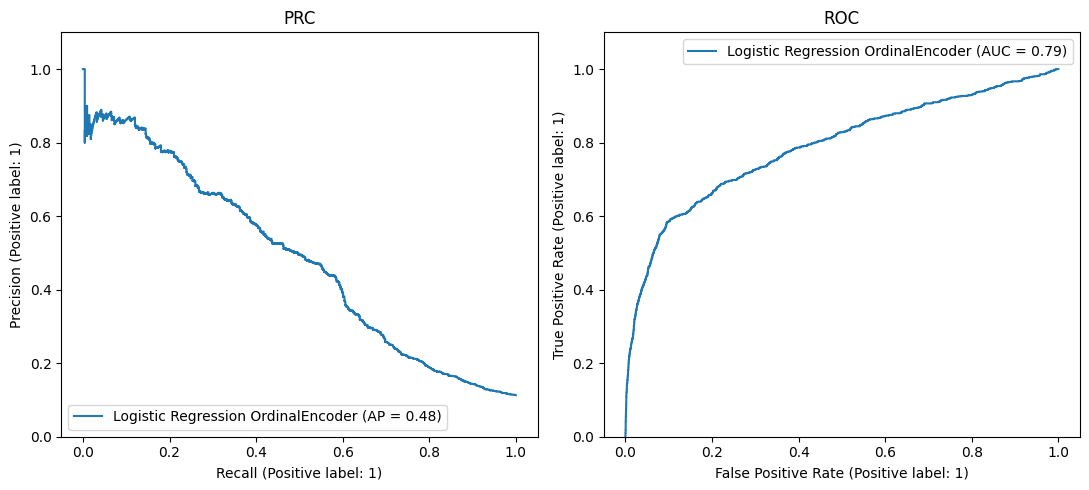

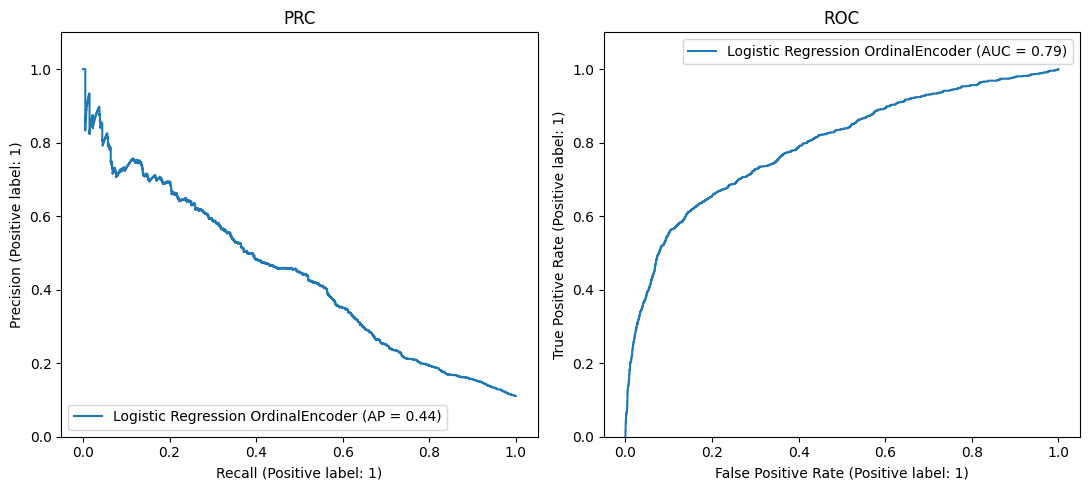

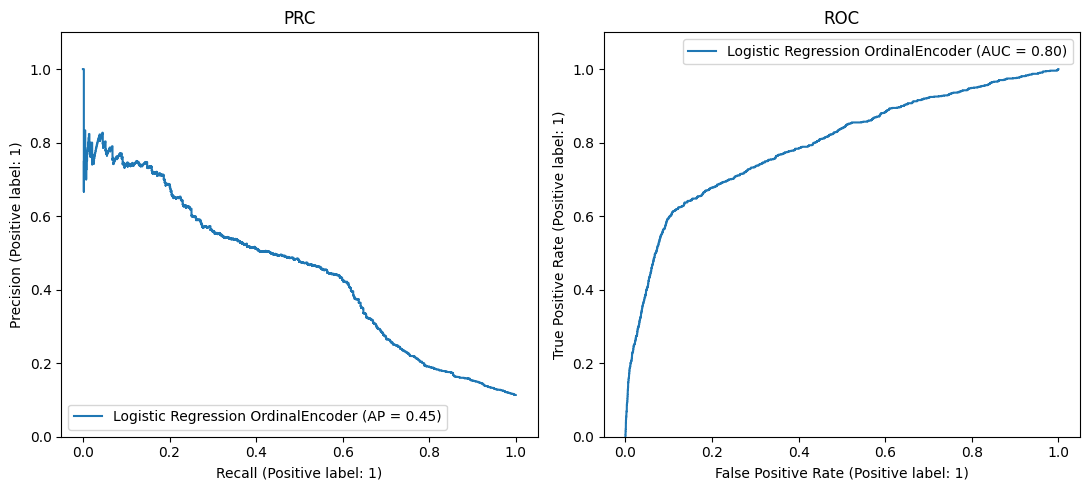

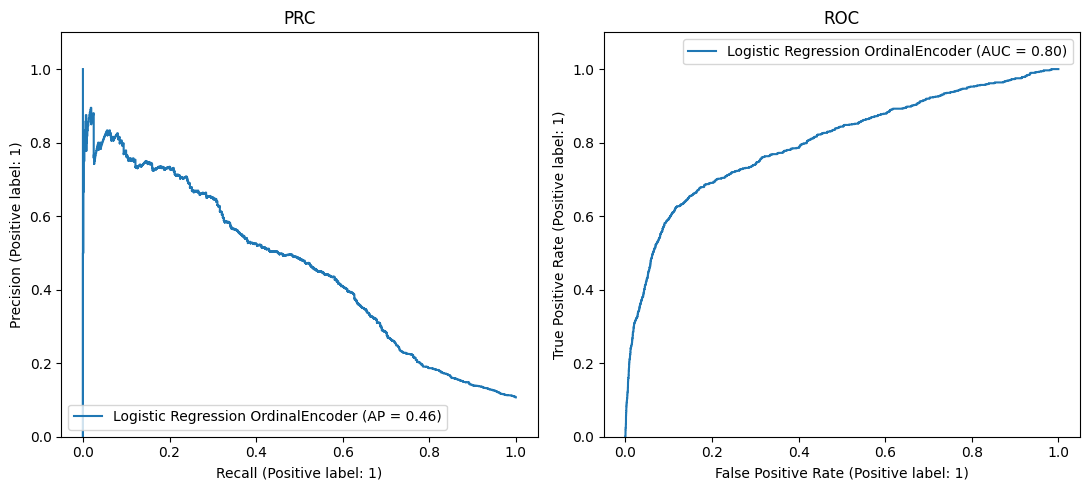

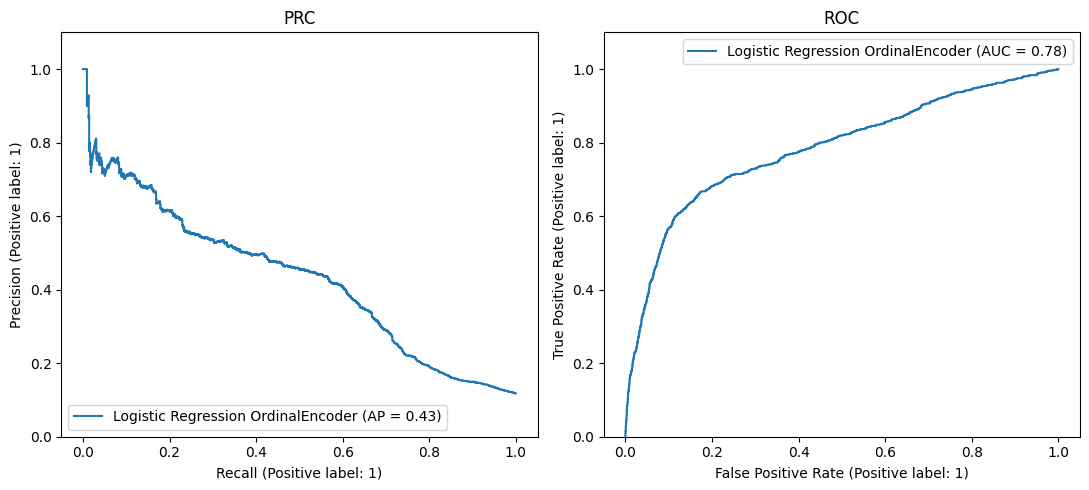

In [243]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_predict


numeric_features_idx = [X.columns.get_loc(col_name) for col_name in numerical]
categorical_features_idx = [X.columns.get_loc(col_name) for col_name in categorical]


def construct_pipeline(model_kwargs: dict = {}):
    logistic_regression_model = LogisticRegression(**model_kwargs)
    numeric_transformer = StandardScaler()
    categorical_transformer = OneHotEncoder(handle_unknown="infrequent_if_exist")

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features_idx),
            ('cat', categorical_transformer, categorical_features_idx)
        ])

    model = Pipeline(steps=[('preprocessor', preprocessor),
                            ('classifier', logistic_regression_model)])
    return model


model = construct_pipeline()
preds = []
for i in range(len(data["X_train"])):
    model.fit(data["X_train"][i], data["y_train"][i])
    auc_roc_ohe, auc_pr_ohe = experiment(model, data["X_test"][i], data["y_test"][i])
    preds.append((auc_roc_ohe, auc_pr_ohe))


Допустим, работники вашего колл-центра получают за один звонок клиенту 1 доллар. При согласии клиента на предлагаемые условия он принесет в банк 10 долларов. Предположим, что всем положительным прогнозам ваши сотрудники решили позвонить. Посчитайте на всех тестовых выборках выручку и усредните. Также вычислите стандартное отклонение.
- Сколько денег вы в среднем заработаете?
- Сколько из заработанных денег придётся отдать операторам вашего колл-центра?

In [244]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

def calculate_profit(X_test, y_test, model):
    y_pred = model.predict(X_test)
    dollars_spent = np.sum(y_pred) * 1

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    dollars_earned = tp * 10

    return dollars_spent, dollars_earned

def average_stats(profit_func, model=model):
    expenses = []
    earnings = []

    for i in range(len(data["X_test"])):
        dollars_spent, dollars_earned = profit_func(data["X_test"][i], data["y_test"][i], model)
        expenses.append(dollars_spent)
        earnings.append(dollars_earned - dollars_spent)
    avg_spent = np.mean(expenses)
    avg_profit = np.mean(earnings)
    print(f"""Отдаем в среднем {avg_spent}\nПрибыль в среднем {avg_profit}""")
    return avg_spent, avg_profit

average_stats(calculate_profit)

Отдаем в среднем 316.6
Прибыль в среднем 1793.4


(316.6, 1793.4)

Внесем некоторую долю случайности. Пусть теперь согласный на условия клиент будет приносить не 10 долларов, а случайную величину, равномерно распределенную в интервале $[0;20)$. Проделайте все те же самые действия. Для имитации реальной ситуации **НЕ** фиксируйте `random_seed` при подсчете выручки с клиента. Что получилось?

In [245]:
def calculate_profit_uniform(X_test, y_test, model):
    y_pred = model.predict(X_test)
    dollars_spent = np.sum(y_pred) * 1

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    dollars_earned = tp * np.random.uniform(0, 20)

    return dollars_spent, dollars_earned

average_stats(calculate_profit_uniform)

Отдаем в среднем 316.6
Прибыль в среднем 2463.6038473169638


(316.6, 2463.6038473169638)

Ну по сути близкие результаты, при увеличении размера выборки, эти результаты стремятся к идентичным. Заметны сильнее различия в прибыли, которая зависит от рандомной переменной.

Настройте по кросс-валидации коэффициент регуляризации модели для максимизации прибыли (считайте как случайную величину выше). Удалось ли получить какой-то выигрыш? При каком коэффициенте регуляризациии прибыль максимальна? Постройте график зависимости ожидаемой прибыли от коэффициента, укажите стандартные отклонения (вам поможет `plt.errorbar`, [пример](https://jakevdp.github.io/PythonDataScienceHandbook/04.03-errorbars.html)).

In [246]:
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
import warnings

@ignore_warnings(category=ConvergenceWarning)
def find_best_regularization(lambdas = np.logspace(-2, 3, 6)):
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning)

        metrics = []
        profits = []
        for l in lambdas:
            metric_scores_specific = []
            for i in range(len(data["X_train"])):
                model = construct_pipeline({"C": l})
                model.fit(data["X_train"][i], data["y_train"][i])
                auc_roc, auc_pr = experiment(model, data["X_test"][i], data["y_test"][i], plot=False, verbose=False)
                metric_scores_specific.append(auc_roc)
            profits.append(average_stats(calculate_profit_uniform, model=model)[1])
            metrics.append(np.mean(metric_scores_specific))


        l_roc_auc = lambdas[np.argmax(metrics)]
        l_profit = lambdas[np.argmax(profits)]
        print(f"""For ROC-AUC Best Lambda is {l_roc_auc} With quality ROC AUC {np.max(metrics)} and profit: {profits[np.argmax(metrics)]}""")
        print(f"""For Profits Best Lambda is {l_profit} With quality ROC AUC {metrics[np.argmax(profits)]} and profit: {np.max(profits)}""")
        print(metrics, len(np.unique(metrics)) == 1 )
        print(profits)
        return l_roc_auc, l_profit

find_best_regularization()

Отдаем в среднем 284.2
Прибыль в среднем 1606.9029583011575
Отдаем в среднем 313.2
Прибыль в среднем 1767.5803160367857
Отдаем в среднем 316.6
Прибыль в среднем 1963.0405162514078
Отдаем в среднем 320.6
Прибыль в среднем 757.3556593497913
Отдаем в среднем 317.6
Прибыль в среднем 1921.3781889624618
Отдаем в среднем 322.2
Прибыль в среднем 1467.5857397182551
For ROC-AUC Best Lambda is 100.0 With quality ROC AUC 0.7926259111975847 and profit: 1921.3781889624618
For Profits Best Lambda is 1.0 With quality ROC AUC 0.7924422814064467 and profit: 1963.0405162514078
[0.7900343647677734, 0.7918378588402898, 0.7924422814064467, 0.7925444723175008, 0.7926259111975847, 0.7924868470213189] False
[1606.9029583011575, 1767.5803160367857, 1963.0405162514078, 757.3556593497913, 1921.3781889624618, 1467.5857397182551]


(100.0, 1.0)

Попробуйте запустить перебор несколько раз. Находится ли каждый раз один и тот же "лучший" коэффициент? Присутствует ли какая-то закономерность? Какие вы можете сделать из этого выводы?

In [247]:
find_best_regularization()

Отдаем в среднем 284.2
Прибыль в среднем 1505.5131509364567
Отдаем в среднем 313.2
Прибыль в среднем 980.4671481308839
Отдаем в среднем 316.6
Прибыль в среднем 1900.9944417829997
Отдаем в среднем 320.6
Прибыль в среднем 2053.777355786494
Отдаем в среднем 317.6
Прибыль в среднем 2301.7593434603423
Отдаем в среднем 322.2
Прибыль в среднем 845.7057876627096
For ROC-AUC Best Lambda is 100.0 With quality ROC AUC 0.7926259111975847 and profit: 2301.7593434603423
For Profits Best Lambda is 100.0 With quality ROC AUC 0.7926259111975847 and profit: 2301.7593434603423
[0.7900343647677734, 0.7918378588402898, 0.7924422814064467, 0.7925444723175008, 0.7926259111975847, 0.7924868470213189] False
[1505.5131509364567, 980.4671481308839, 1900.9944417829997, 2053.777355786494, 2301.7593434603423, 845.7057876627096]


(100.0, 100.0)

In [248]:
find_best_regularization()

Отдаем в среднем 284.2
Прибыль в среднем 2598.8517358103713
Отдаем в среднем 313.2
Прибыль в среднем 1101.4553382364466
Отдаем в среднем 316.6
Прибыль в среднем 958.4147531425584
Отдаем в среднем 320.6
Прибыль в среднем 688.6924959337374
Отдаем в среднем 317.6
Прибыль в среднем 1880.735106788709
Отдаем в среднем 322.2
Прибыль в среднем 2055.829768103759
For ROC-AUC Best Lambda is 100.0 With quality ROC AUC 0.7926259111975847 and profit: 1880.735106788709
For Profits Best Lambda is 0.01 With quality ROC AUC 0.7900343647677734 and profit: 2598.8517358103713
[0.7900343647677734, 0.7918378588402898, 0.7924422814064467, 0.7925444723175008, 0.7926259111975847, 0.7924868470213189] False
[2598.8517358103713, 1101.4553382364466, 958.4147531425584, 688.6924959337374, 1880.735106788709, 2055.829768103759]


(100.0, 0.01)

##### ROC-кривые для AUC очень стабильные. Оптимизируя по ним, мы получаем всегда один и тот же коэффициент. Рандомная переменная из-за волатильности выдает разные коэффициенты регуляризации. Вывод: Опираемся на ROC кривые. На случайные переменные ориентироваться стоит меньше! Забавно, что

#### __Задание 13. Ключевая метрика__ (1 балл)

Выше мы уже описали примерную экономическую модель вашей задачи. Как вы считаете, что для вашего бизнеса важнее — хороший precision или recall модели? Почему?

__Ответ:__ # precision = $\frac{TP}{TP+FP}$, recall = $\frac{TP}{TP+FN}$ <br> Что нам важнее, чтобы мы никогда не потарили доллар зря? или чтобы мы позвонили каждому клиенту ценою того, что потратим лишние доллары? <br>
Одного правильно классифицированного клиента хватит для того, чтобы покрыть 9 клиентов, которые были ложно классифицированы положительными, поэтому recall здесь важнее. Выходя за рамки задачи, обычно клиент конвертируется в долгосрочного, поэтому опять же recall выигрывает



In [249]:
sum(y[y==1]) / len(y)

0.11265417111780131

> Вспомним, что на самом деле логистическая регрессия предсказывает нам вероятности положительного класса для объекта. Возможно, путем настройки __порога бинаризации__ этих вероятностей мы сможем получить какой-то выигрыш?

Проверьте ваши рассуждения выше с помощью настройки порога бинаризации на кросс-валидации для максимизации прибыли. Воспользуйтесь сеткой от 0 до 1 с шагом 0.01. Напомним, что снижение порога дает нам более высокий recall и более низкий precision, и наоборот.

In [250]:
thresholds = np.linspace(0,1,100)

Постройте график зависимости прибыли от порога бинаризации, также отметьте на нем стандартные отклонения. Выделите наилучший порог.




In [259]:
%%capture

def calculate_profit_uniform_threshold(X_test, y_test, model, t):
    y_pred = np.where(model.predict_proba(X_test)[:,1] > t, 1, 0)
    dollars_spent = np.sum(y_pred) * 1

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    dollars_earned = tp * np.random.uniform(0, 20)

    return dollars_spent, dollars_earned

def find_best_threshold(thresholds, profit_func_with_t):
    profits = []
    for t in thresholds:
        expenses = []
        earnings = []

        for i in range(len(data["X_test"])):
            dollars_spent, dollars_earned = profit_func_with_t(
                data["X_test"][i], data["y_test"][i], model, t=t)

            expenses.append(dollars_spent)
            earnings.append(dollars_earned - dollars_spent)
        avg_spent = np.mean(expenses)
        avg_profit = np.mean(earnings)
        print(f"""Отдаем в среднем {avg_spent}\nПрибыль в среднем {avg_profit}""")

        profits.append(avg_profit)
    return profits

profits = find_best_threshold(thresholds, calculate_profit_uniform_threshold)

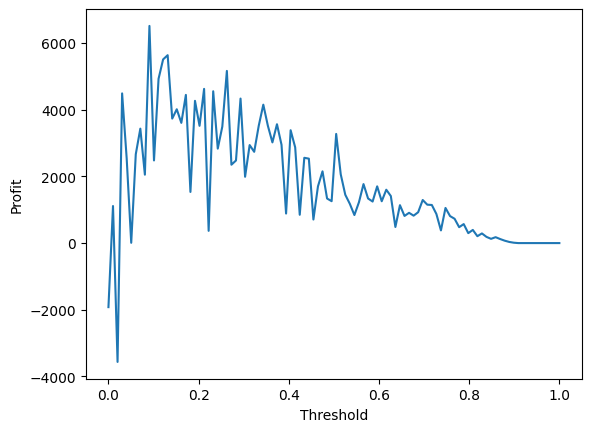

In [260]:
plt.plot(thresholds, profits)
plt.xlabel("Threshold")
plt.ylabel("Profit")

plt.show()

__Вопрос:__ Замечаете ли вы какую-то закономерность? Для правильного ответа на этот вопрос попробуйте запустить несколько раз и задумайтесь, почему порог получается в какой-то конкретной области?

Отдаем в среднем 8237.6
Прибыль в среднем 3439.6662667994897
Отдаем в среднем 8232.2
Прибыль в среднем 1175.333641520771
Отдаем в среднем 8085.8
Прибыль в среднем 3358.525959143146
Отдаем в среднем 7151.6
Прибыль в среднем 2852.639383381824
Отдаем в среднем 5922.4
Прибыль в среднем 5420.948385146661
Отдаем в среднем 4908.8
Прибыль в среднем 1404.6679758745538
Отдаем в среднем 3815.8
Прибыль в среднем 3954.742509360543
Отдаем в среднем 2950.4
Прибыль в среднем 5015.51138840911
Отдаем в среднем 2422.8
Прибыль в среднем 5027.504983517609
Отдаем в среднем 2103.6
Прибыль в среднем 902.1905257111772
Отдаем в среднем 1899.2
Прибыль в среднем 3909.056708332007
Отдаем в среднем 1728.0
Прибыль в среднем 5515.643868265747
Отдаем в среднем 1591.8
Прибыль в среднем 2745.897555447137
Отдаем в среднем 1489.2
Прибыль в среднем 5223.2301766851015
Отдаем в среднем 1423.4
Прибыль в среднем 6113.371136552276
Отдаем в среднем 1380.4
Прибыль в среднем 4650.704784950212
Отдаем в среднем 1340.2
Прибыль в сред

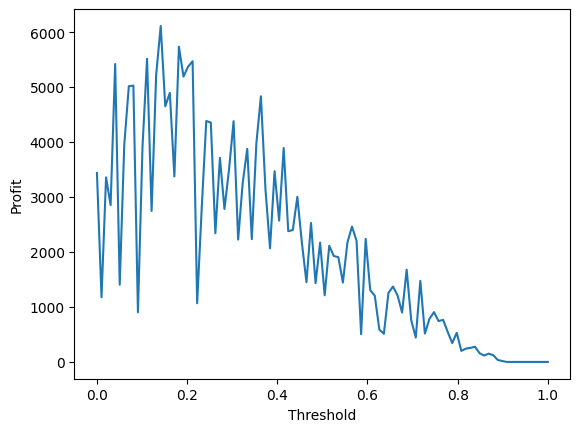

In [261]:
profits = find_best_threshold(thresholds, calculate_profit_uniform_threshold)

plt.plot(thresholds, profits)
plt.xlabel("Threshold")
plt.ylabel("Profit")

plt.show()

Отдаем в среднем 8237.6
Прибыль в среднем 4145.999710321242
Отдаем в среднем 8232.2
Прибыль в среднем 92.15138283484812
Отдаем в среднем 8085.8
Прибыль в среднем 1067.4206608344798
Отдаем в среднем 7151.6
Прибыль в среднем 6848.496332028308
Отдаем в среднем 5922.4
Прибыль в среднем 2890.3847880171547
Отдаем в среднем 4908.8
Прибыль в среднем 1056.039905130292
Отдаем в среднем 3815.8
Прибыль в среднем 1475.946187902546
Отдаем в среднем 2950.4
Прибыль в среднем 2168.830976106737
Отдаем в среднем 2422.8
Прибыль в среднем 4643.449800555122
Отдаем в среднем 2103.6
Прибыль в среднем 2853.092427861816
Отдаем в среднем 1899.2
Прибыль в среднем 8421.75310498044
Отдаем в среднем 1728.0
Прибыль в среднем 4108.61854940147
Отдаем в среднем 1591.8
Прибыль в среднем 5011.749382047619
Отдаем в среднем 1489.2
Прибыль в среднем 7714.906456205179
Отдаем в среднем 1423.4
Прибыль в среднем 6101.166348137087
Отдаем в среднем 1380.4
Прибыль в среднем 3873.529186197701
Отдаем в среднем 1340.2
Прибыль в средне

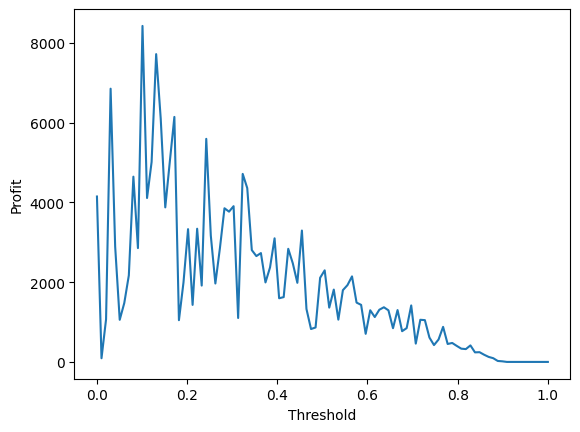

In [262]:
profits = find_best_threshold(thresholds, calculate_profit_uniform_threshold)

plt.plot(thresholds, profits)
plt.xlabel("Threshold")
plt.ylabel("Profit")

plt.show()

__Ответ:__ лучший порог получается между 0.1 и 0.2. Потому что мы можем зафейлится и набрать несколько раз тем, в ком мы мало уверенны, в среднем они дают в 10 раз больше, чем мы расходуем на эти звонки. Низкий Threshold => высокий recall, низкий precision

Каковы значения precision и recall на выбранном пороге? Оцените по кросс-валидации. Также вычислите стандартное отклонение.

In [263]:
best_t = thresholds[np.argmax(profits)]
best_t

0.10101010101010102

In [271]:
from sklearn.metrics import precision_score, recall_score

@ignore_warnings(category=ConvergenceWarning)
def calculate_metrics():
    precision = []
    recall = []

    for i in range(len(data["X_train"])):
        model.fit(data["X_train"][i], data["y_train"][i])
        y_pred = np.where(model.predict_proba(data["X_test"][i])[:,1] > best_t, 1, 0)
        y_true = data["y_test"][i]

        precision.append(precision_score(y_true, y_pred))
        recall.append(recall_score(y_true, y_pred))

    print(f"Precision: {np.mean(precision)}, Std: {np.std(precision)}")
    print(f"Recall: {np.mean(recall)}, Std: {np.std(recall)}")

calculate_metrics()

Precision: 0.31639514357296117, Std: 0.014119174027503529
Recall: 0.6605260132662137, Std: 0.021060297422194865


Можно пронаблюдать, что наша модель склоняется к более высокому recall. Попробуйте оценить качество модели с помощью `PR-AUC` в зоне recall $\geq$ 0.5. Сделайте это следующим образом:
- выберите только те пороги, на которых достигается необходимый recall,
- затем интерпретируйте отсеченный в единичном квадрате прямоугольник как новый единичный квадрат,
- посчитайте площадь под отсеченной кривой

In [ ]:
recall = []
for t in thresholds:
    recalls_for_fold = []
    for i in range(len(data["X_test"])):
        model.fit(data["X_train"][i], data["y_train"][i])

        y_pred = np.where(model.predict_proba(data["X_test"][i])[:,1] > best_t, 1, 0)
        y_true = data["y_test"][i]

        recalls_for_fold.append(recall_score(y_true, y_pred))
    recall.append(np.mean(recalls_for_fold))

plt.show(thresholds, recall)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

__Бонус (0.01 балла):__ что вы кушали в день сдачи данного ДЗ на завтрак?

__Ответ:__ #your answer here